# Regression Experiments 2

My previous notebook was getting a little bit messy, so I decided to make this to make the code a little more structured. This notebook includes some convenience functions, which should make the experiments a little more readable.

# Setup:

---

In [1]:
# Required imports
import pandas as pd
import json

rounded_train = pd.read_csv('../data/train_with_rounded_score.csv')
rounded_test = pd.read_csv('../data/test_with_rounded_score.csv')
raw_train = pd.read_csv('../data/train_with_raw_score.csv')
raw_test = pd.read_csv('../data/test_with_raw_score.csv')
fips_map = open('../data/fips_map.json')
fips_map = json.load(fips_map)

In [2]:
# Convenience function to get coordinates from fips code
from functools import lru_cache
@lru_cache(maxsize=10000)
def fips_to_coordinate(fips_code):
    fips_code = str(fips_code)
    if fips_code in fips_map:
        return [fips_map[fips_code]['lat'], fips_map[fips_code]['long']]
    else:
        return [None, None]


In [3]:
#add a lat and long column without dropping the fips column
def interpret_fips(df):
    '''Turn the fips column into a latitude/longitude pair'''
    coords = pd.DataFrame(df['fips'].apply(fips_to_coordinate).tolist(), columns=['lat', 'long'])
    df = pd.concat([df, coords], axis=1)
    return df

In [4]:
def add_lag_features(groupbykey:str,shiftcol:str,shiftnum:int,basenum:int,df:pd.DataFrame):
    '''
    This convenience function lags the shiftcol by num_weeks after grouping by groupby.
    The basenum is the number of weeks to ignore before adding lag. For example, 
    If you want to lag the most recent week, you would have a base of 0, and a num_weeks of 1.
    If you want to lag only the week before the most recent week, you would have a base of 1, and a num_weeks of 1. 
    The shiftcol is the metric you want to add lag features for.
    '''
    for i in range(basenum+1,shiftnum+1):
        df[f'{shiftcol}_lag_{i}'] = df.groupby([groupbykey])[shiftcol].shift(i)
    return df

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

def regression_metric(y_true,y_pred,title:str):
    '''Generates a standard regression metric set, as well as a scatter plot to visualize'''
    plt.figure(figsize=(20,10))
    plt.scatter(y_true, y_pred)
    plt.scatter(y_true, y_true)
    plt.title(title+" model vs truth")
    plt.legend(['Model','Truth'])
    plt.xlabel('Real Score')
    plt.ylabel('Predicted Score')
    plt.show()

    # Error metrics
    print("Mean Squared Error: ", mean_squared_error(y_true, y_pred))
    print("Mean Absolute Error: ", mean_absolute_error(y_true, y_pred))
    print("R2 Score: ", r2_score(y_true, y_pred))


In [6]:
def shift_target(df:pd.DataFrame, num_weeks:int, target_col:str, groupy:str)->pd.DataFrame:
    '''Shifts the target column by num_weeks after grouping by groupy.'''
    '''The target_col should be the name of the column you are trying to predict.'''
    '''The groupy should be the column you are grouping by. (Most often for us, this will be 'fips')'''
    '''The num_weeks should be the number of weeks you want to shift the target column by.(How far out you want to predict)'''
    '''The df should be the dataframe you are working with.'''
    newdf = df.copy()
    newdf[target_col] = df.groupby([groupy])[target_col].shift(-num_weeks)
    return newdf

In [7]:
def get_fresh_data():
    '''Returns fresh copy of data with some basic preprocessing'''
    _train = raw_train.copy()
    _test = raw_test.copy()
    _train = interpret_fips(_train)
    _test = interpret_fips(_test)
    _train.set_index('date', inplace=True)
    _test.set_index('date', inplace=True)
    return _train, _test

In [8]:
def rm_fips_null(df):
    '''removes fips and all null values'''
    df.drop(['fips'], axis=1, inplace=True)
    df.dropna(inplace=True)
    return df

# Experiments:

---

### Basic Catboost Regressor with default parameters, score lag of 4 weeks.

---

In [ ]:
train2 = raw_train.copy()  #REQUIRED STEP
test2 = raw_test.copy() #REQUIRED STEP

In [ ]:
train2 = interpret_fips(train2) #REQUIRED STEP
test2 = interpret_fips(test2) #REQUIRED STEP
train2.set_index('date',inplace=True) #REQUIRED STEP
test2.set_index('date',inplace=True) #REQUIRED STEP
train2 = add_lag_features('fips','score',4,0,train2) #can play around with these
test2 = add_lag_features('fips','score',4,0,test2)

In [ ]:
NUM_WEEKS_TO_FORECAST = 1

In [ ]:
train2 = shift_target(train2, NUM_WEEKS_TO_FORECAST, 'score', 'fips') #REQUIRED STEP, but you can change the number of weeks to forecast
test2 = shift_target(test2, NUM_WEEKS_TO_FORECAST, 'score', 'fips')

In [ ]:
train2.drop(['fips'],axis=1,inplace=True) #REQUIRED STEP
test2.drop(['fips'],axis=1,inplace=True) #REQUIRED STEP
train2.dropna(inplace=True) #REQUIRED STEP
test2.dropna(inplace=True)  #REQUIRED STEP

In [ ]:
from catboost import CatBoostRegressor

model2 = CatBoostRegressor()

model2.fit(train2.drop(['score'],axis=1),train2['score'], verbose=False)

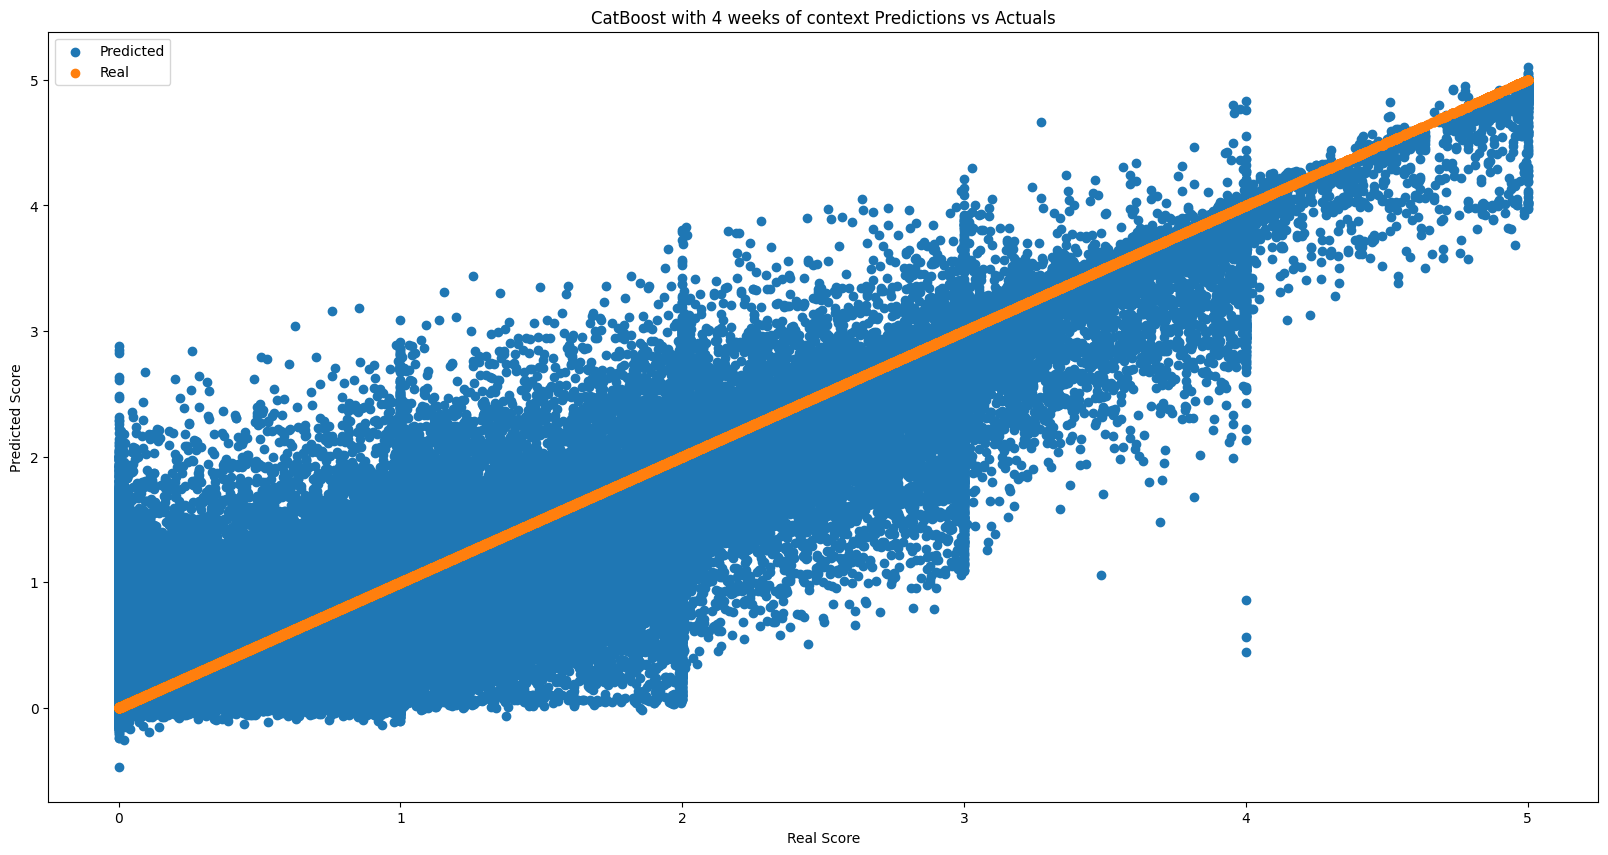

Mean Squared Error:  0.10298512832055014
Mean Absolute Error:  0.17302552702864524
Mean Absolute Percentage Error:  246714846078534.28
R2 Score:  0.8554472329258824


In [ ]:
model2_preds = model2.predict(test2.drop(['score'],axis=1))

regression_metric(test2['score'], model2_preds, 'CatBoost with 4 weeks of context')

In [ ]:
model2.get_feature_importance(prettified=True)

,Feature Id,Importances
0,score_lag_1,73.051489
1,long,3.611388
2,PRECTOT,3.317619
3,T2M_MAX,2.917899
4,QV2M,2.105821
5,lat,1.936232
6,score_lag_2,1.754923
7,TS,1.437189
8,T2M_MIN,1.336508
9,T2M_RANGE,1.272088


In [ ]:
from catboost import CatBoostRegressor
def cbm_model(num_weeks_to_forecast):
    '''wraps all of the logic above into a single function'''
    _train = raw_train.copy()
    _test = raw_test.copy()
    _train = interpret_fips(_train)
    _test = interpret_fips(_test)
    _train.set_index('date',inplace=True)
    _test.set_index('date',inplace=True)
    _train = add_lag_features('fips','score',4,0,_train)
    _test = add_lag_features('fips','score',4,0,_test)
    _train = shift_target(_train, num_weeks_to_forecast, 'score', 'fips')
    _test = shift_target(_test, num_weeks_to_forecast, 'score', 'fips')
    _train.drop(['fips'],axis=1,inplace=True)
    _test.drop(['fips'],axis=1,inplace=True)
    _train.dropna(inplace=True)
    _test.dropna(inplace=True)
    _model = CatBoostRegressor()
    _model.fit(_train.drop(['score'],axis=1),_train['score'], verbose=False)
    _model_preds = _model.predict(_test.drop(['score'],axis=1))
    regression_metric(_test['score'], _model_preds, f'CatBoost with 4 weeks of context, forecasting {num_weeks_to_forecast} weeks ahead')
    return _model   

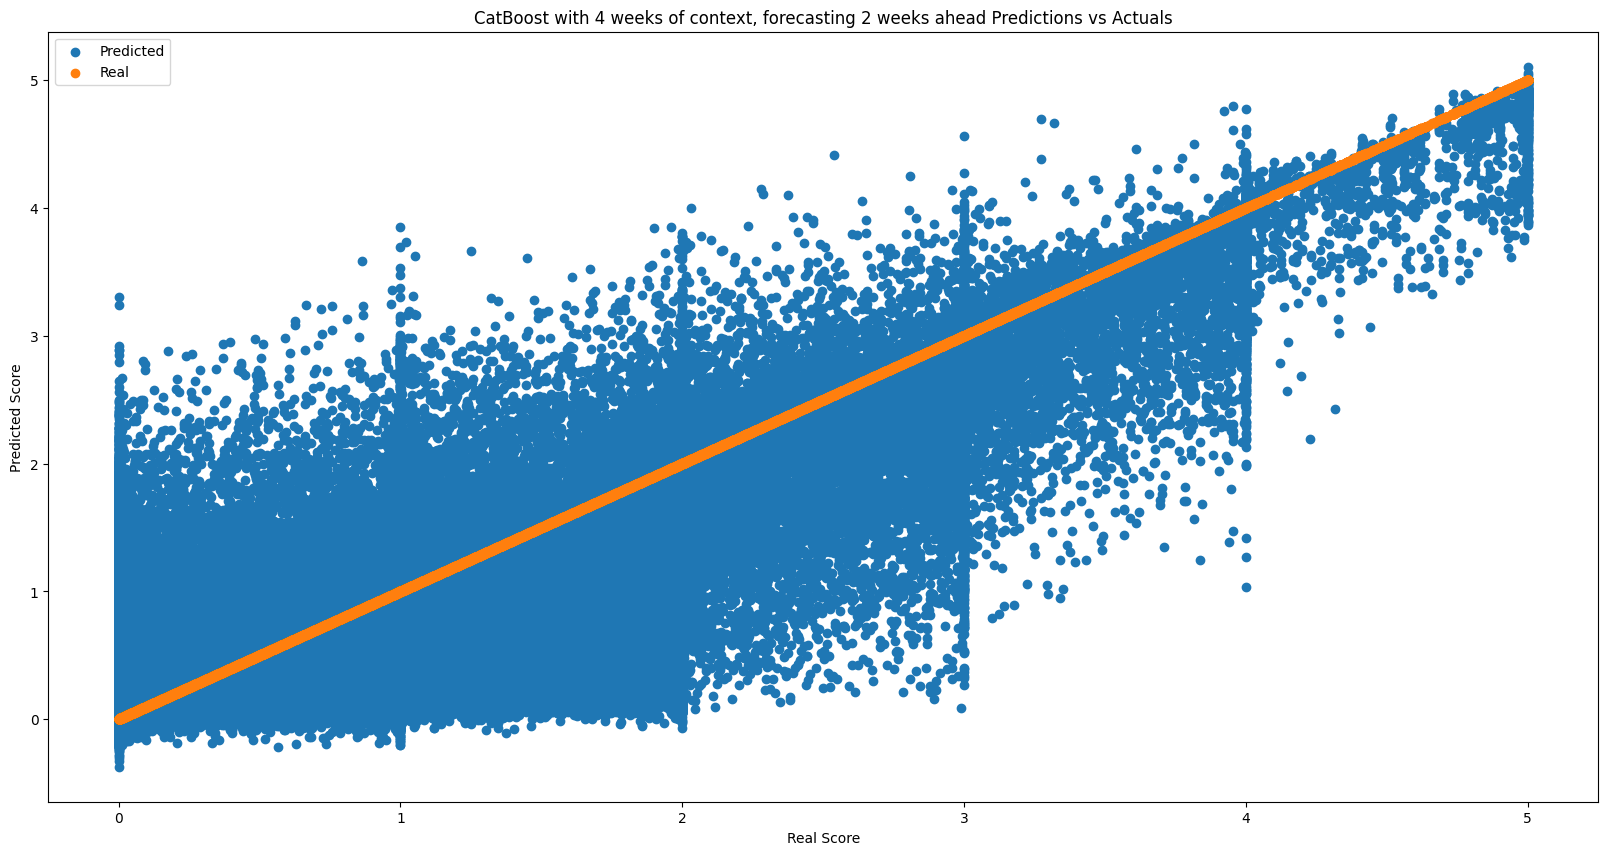

Mean Squared Error:  0.15905894535038387
Mean Absolute Error:  0.23070245007359735
Mean Absolute Percentage Error:  361979271442672.1
R2 Score:  0.7776244687679325


In [ ]:
cbm_model(2)

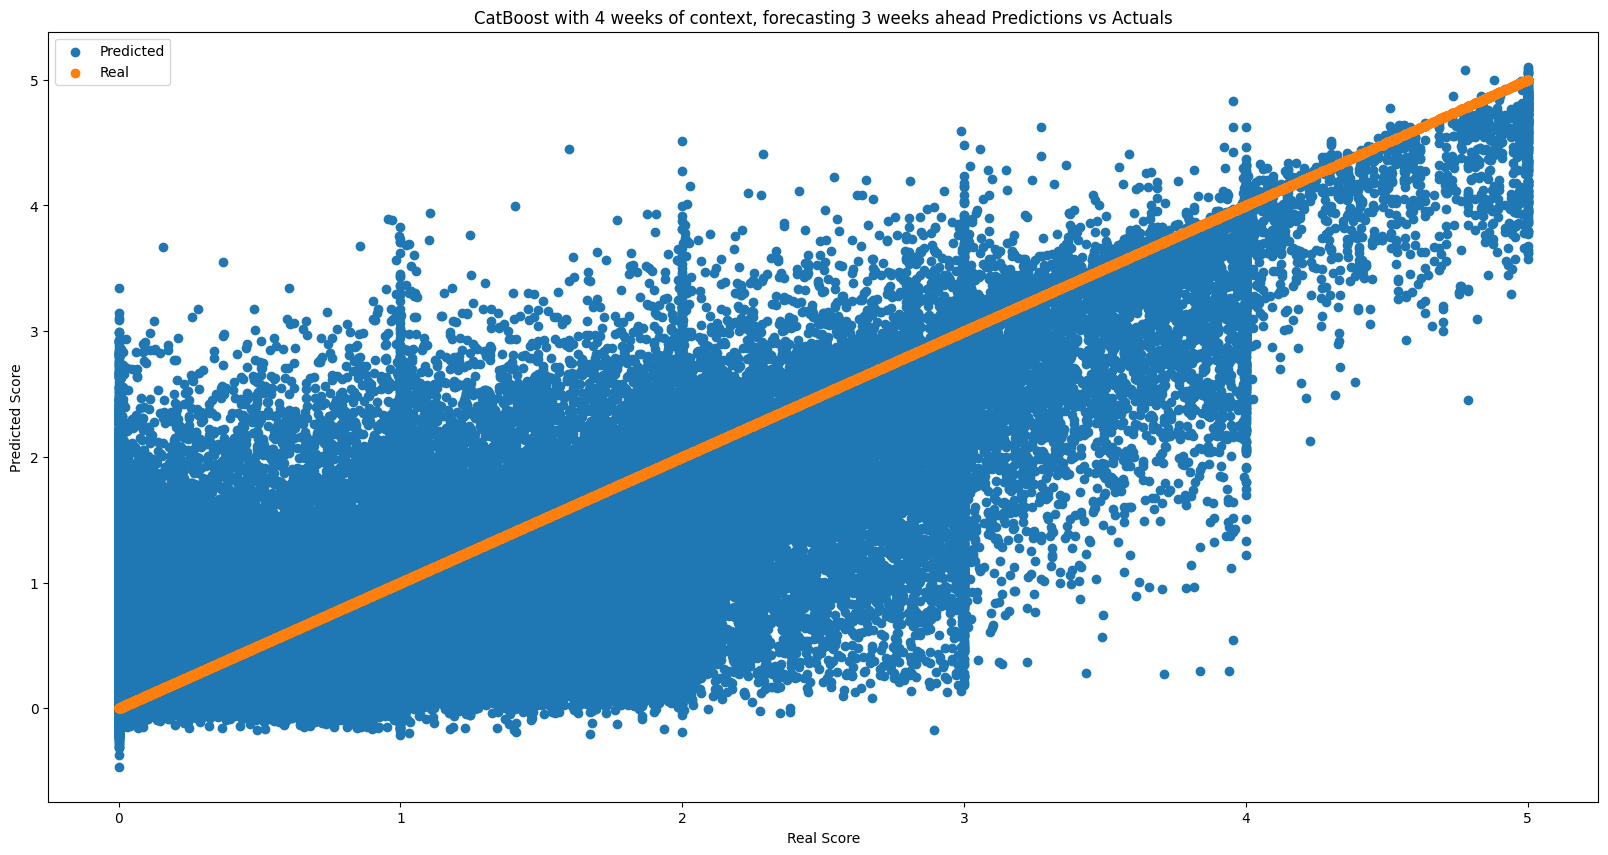

Mean Squared Error:  0.21647235239802437
Mean Absolute Error:  0.2813972707527741
Mean Absolute Percentage Error:  471434156743641.0
R2 Score:  0.6986475132662542


In [ ]:
cbm_model(3)

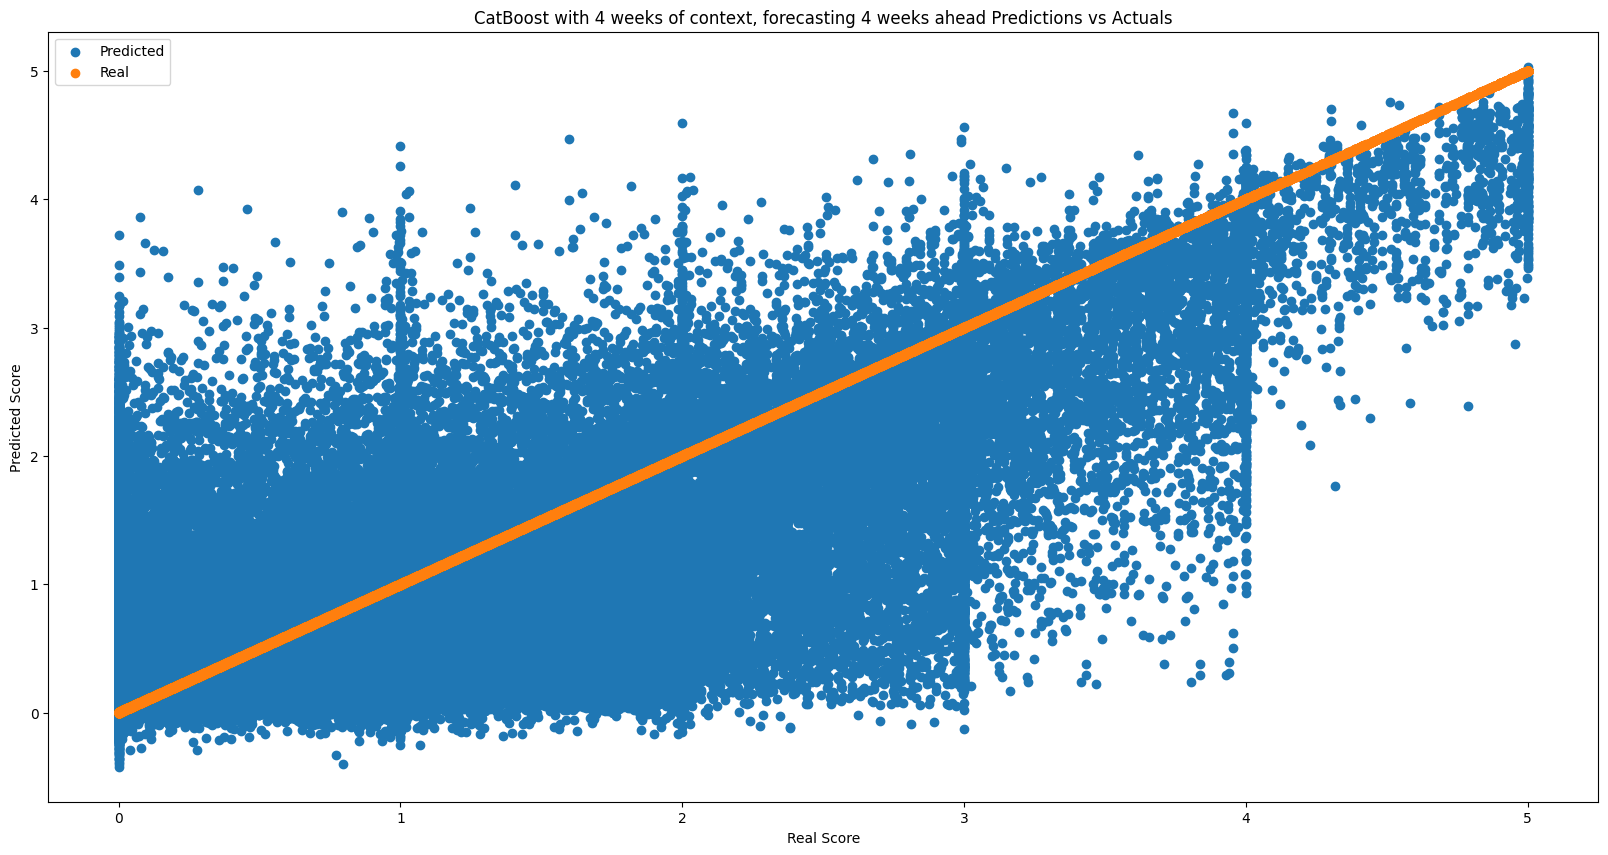

Mean Squared Error:  0.2736729260587206
Mean Absolute Error:  0.32626078414695003
Mean Absolute Percentage Error:  574751068893957.1
R2 Score:  0.6208037087985516


In [ ]:
cbm_model(4)

### Basic Catboost Regressor, 8 week lag, offset by 2 weeks.

---
I want to see if more score lag data but offset by 2 weeks will preserve the score

In [ ]:
train3, test3 = get_fresh_data()
train3 = add_lag_features('fips','score',8,2,train3)
test3 = add_lag_features('fips','score',8,2,test3)
train3 = shift_target(train3, NUM_WEEKS_TO_FORECAST, 'score', 'fips')
test3 = shift_target(test3, NUM_WEEKS_TO_FORECAST, 'score', 'fips')
train3 = rm_fips_null(train3)
test3 = rm_fips_null(test3)

In [ ]:
from catboost import CatBoostRegressor

model3 = CatBoostRegressor()
model3.fit(train3.drop(['score'],axis=1),train3['score'], verbose=False)

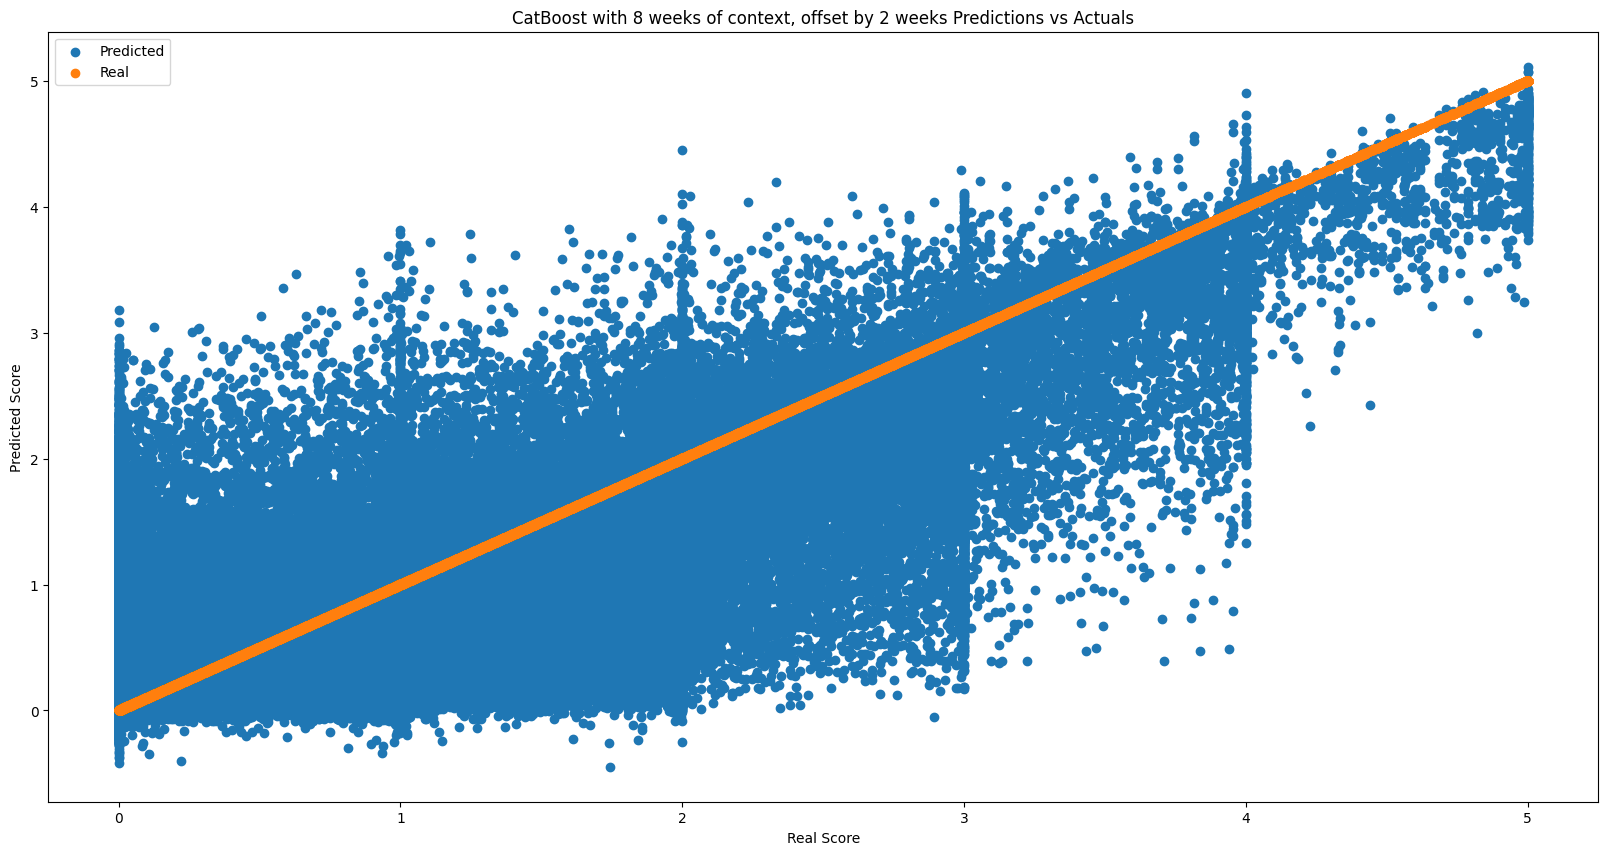

Mean Squared Error:  0.21087944545658036
Mean Absolute Error:  0.27516168794014756
Mean Absolute Percentage Error:  444063306072515.8
R2 Score:  0.7094080353089778


In [ ]:
model3_preds = model3.predict(test3.drop(['score'],axis=1))
regression_metric(test3['score'], model3_preds, 'CatBoost with 8 weeks of context, offset by 2 weeks')

### Basic CatBoost Regressor, very little score lag, mostly measurement lag

---

In [ ]:
train4, test4 = get_fresh_data()

In [ ]:
cols = train4.columns.to_list()
cols.remove('fips')
cols.remove('score')
cols.remove('lat')
cols.remove('long')
for x in cols:
    train4 = add_lag_features('fips',x,4,0,train4)
    test4 = add_lag_features('fips',x,4,0,test4)

train4 = add_lag_features('fips','score',4,2,train4)
test4 = add_lag_features('fips','score',4,2,test4)

In [ ]:
NUM_WEEKS_TO_FORECAST = 1

In [ ]:
train4 = shift_target(train4, NUM_WEEKS_TO_FORECAST, 'score', 'fips')
test4 = shift_target(test4, NUM_WEEKS_TO_FORECAST, 'score', 'fips')
train4 = rm_fips_null(train4)
test4 = rm_fips_null(test4)

In [ ]:
train4.head()

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,...,WS50M_MIN_lag_1,WS50M_MIN_lag_2,WS50M_MIN_lag_3,WS50M_MIN_lag_4,WS50M_RANGE_lag_1,WS50M_RANGE_lag_2,WS50M_RANGE_lag_3,WS50M_RANGE_lag_4,score_lag_3,score_lag_4
date,,,,,,,,,,,,,,,,,,,,,
2000-02-01,0.00,101.00,3.36,2.06,-1.73,-1.70,11.02,-4.21,15.23,1.88,...,3.96,3.84,1.71,3.74,4.07,2.55,4.67,5.58,2.0,1.0
2000-02-08,0.00,101.04,5.01,8.88,3.90,3.91,17.64,2.65,14.99,8.31,...,1.27,3.96,3.84,1.71,5.11,4.07,2.55,4.67,2.0,2.0
2000-02-15,0.00,100.68,5.84,10.94,5.84,5.84,20.57,2.05,18.52,10.96,...,0.69,1.27,3.96,3.84,4.63,5.11,4.07,2.55,2.0,2.0
2000-02-22,0.36,101.34,5.03,10.02,3.99,4.00,18.57,2.49,16.08,10.07,...,2.57,0.69,1.27,3.96,5.07,4.63,5.11,4.07,1.0,2.0
2000-02-29,0.01,100.71,6.52,12.61,7.49,7.49,21.52,4.27,17.25,12.61,...,2.67,2.57,0.69,1.27,4.46,5.07,4.63,5.11,1.0,1.0


In [ ]:
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# import numpy as np

# pca = PCA(n_components=93)
# pca.fit(train4.drop(['score'],axis=1))

In [ ]:
# plt.figure(figsize=(40,10))
# plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
# plt.title('Scree Plot')
# plt.xlabel('Principal Component')
# plt.ylabel('Variance Explained')
# plt.show()

In [ ]:
# pca = PCA(n_components=10)
# trainX = pca.fit_transform(train4.drop(['score'],axis=1))
# testX = pca.transform(test4.drop(['score'],axis=1))

trainX = train4.drop(['score'],axis=1)
testX = test4.drop(['score'],axis=1)

In [ ]:
# train catboost regressor
from catboost import CatBoostRegressor
model4 = CatBoostRegressor()
model4.fit(trainX,train4['score'], verbose=True)

Learning rate set to 0.143013
0:	learn: 1.0922019	total: 471ms	remaining: 7m 50s
1:	learn: 0.9828325	total: 969ms	remaining: 8m 3s
2:	learn: 0.8929399	total: 1.45s	remaining: 8m
3:	learn: 0.8194412	total: 1.96s	remaining: 8m 9s
4:	learn: 0.7599749	total: 2.45s	remaining: 8m 6s
5:	learn: 0.7123483	total: 3.12s	remaining: 8m 36s
6:	learn: 0.6741756	total: 3.58s	remaining: 8m 28s
7:	learn: 0.6442718	total: 4.05s	remaining: 8m 22s
8:	learn: 0.6202132	total: 4.49s	remaining: 8m 14s
9:	learn: 0.6011546	total: 4.96s	remaining: 8m 10s
10:	learn: 0.5869294	total: 5.43s	remaining: 8m 7s
11:	learn: 0.5752457	total: 5.87s	remaining: 8m 3s
12:	learn: 0.5660179	total: 6.33s	remaining: 8m
13:	learn: 0.5587696	total: 6.75s	remaining: 7m 55s
14:	learn: 0.5529989	total: 7.19s	remaining: 7m 52s
15:	learn: 0.5482977	total: 7.68s	remaining: 7m 52s
16:	learn: 0.5446428	total: 8.16s	remaining: 7m 51s
17:	learn: 0.5417219	total: 8.6s	remaining: 7m 49s
18:	learn: 0.5387461	total: 9.03s	remaining: 7m 46s
19:	le

In [ ]:
# save catboost regressor
import pickle
pickle.dump(model4, open('model4_regression_experiments.pkl', 'wb'))

In [ ]:
import pickle
import pandas as pd
model4 = pickle.load(open('model4_regression_experiments.pkl', 'rb'))

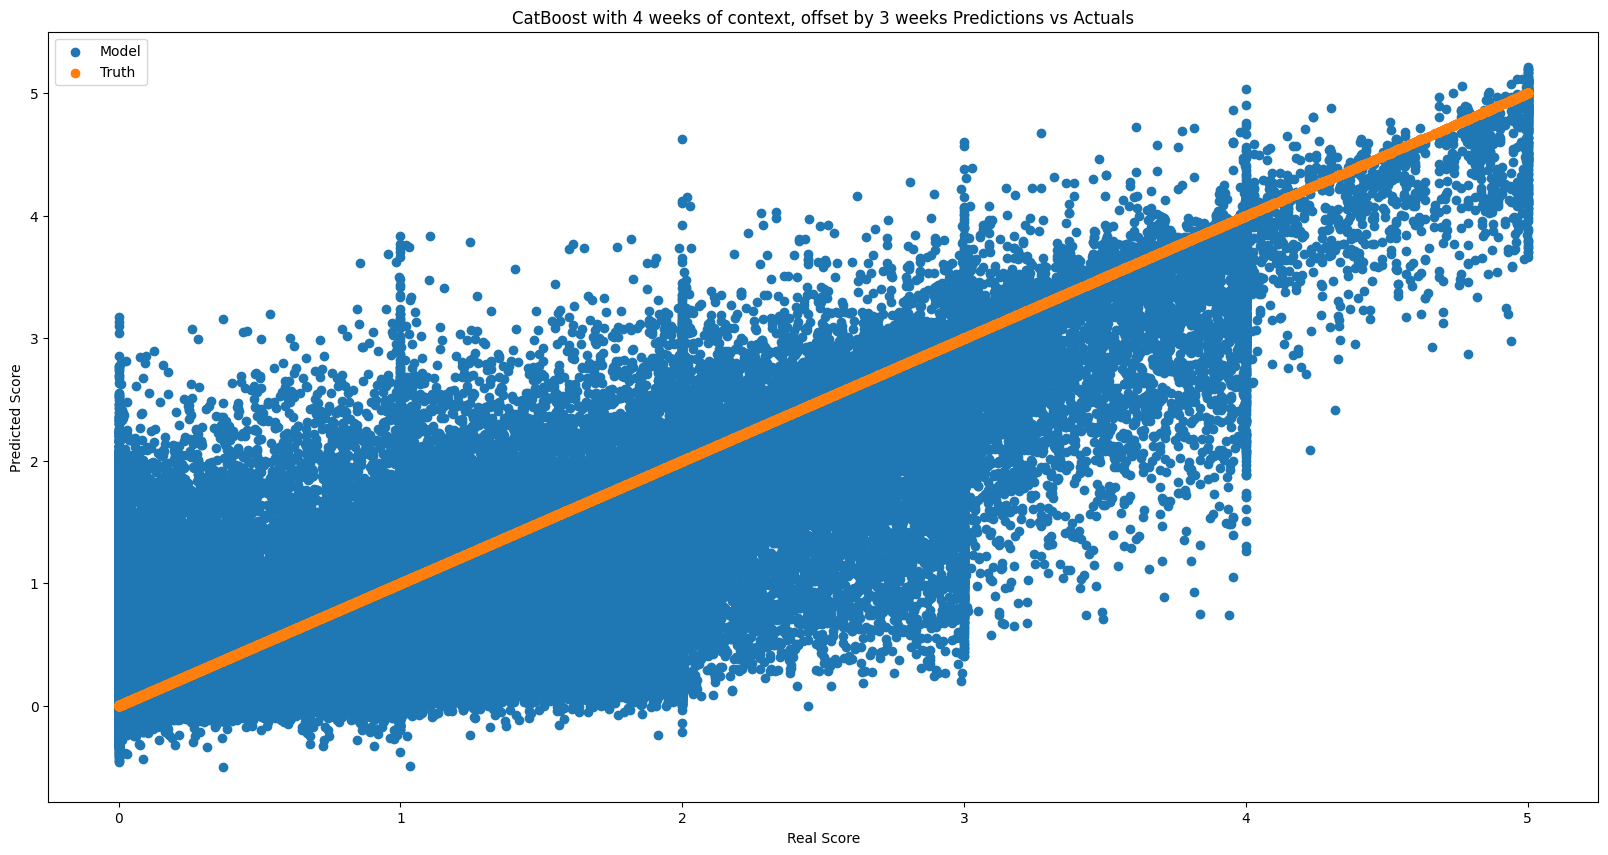

Mean Squared Error:  0.18933409493057926
Mean Absolute Error:  0.26530599076731387
R2 Score:  0.7342454413563362


In [ ]:
# evaluate catboost regressor
model4_preds = model4.predict(testX)
regression_metric(test4['score'], model4_preds, 'CatBoost with 4 weeks of context, offset by 3 weeks') 

### MLP Regressor on the same data as most previous experiment

In [ ]:
#train MLP regressor
from sklearn.neural_network import MLPRegressor

model5 = MLPRegressor()
model5.fit(train4.drop(['score'],axis=1),train4['score'])

MLPRegressor()

In [ ]:
#save MLP regressor
pickle.dump(model5, open('model5_regression_experiments.pkl', 'wb'))

In [ ]:
import pickle
model5 = pickle.load(open('model5_regression_experiments.pkl', 'rb'))

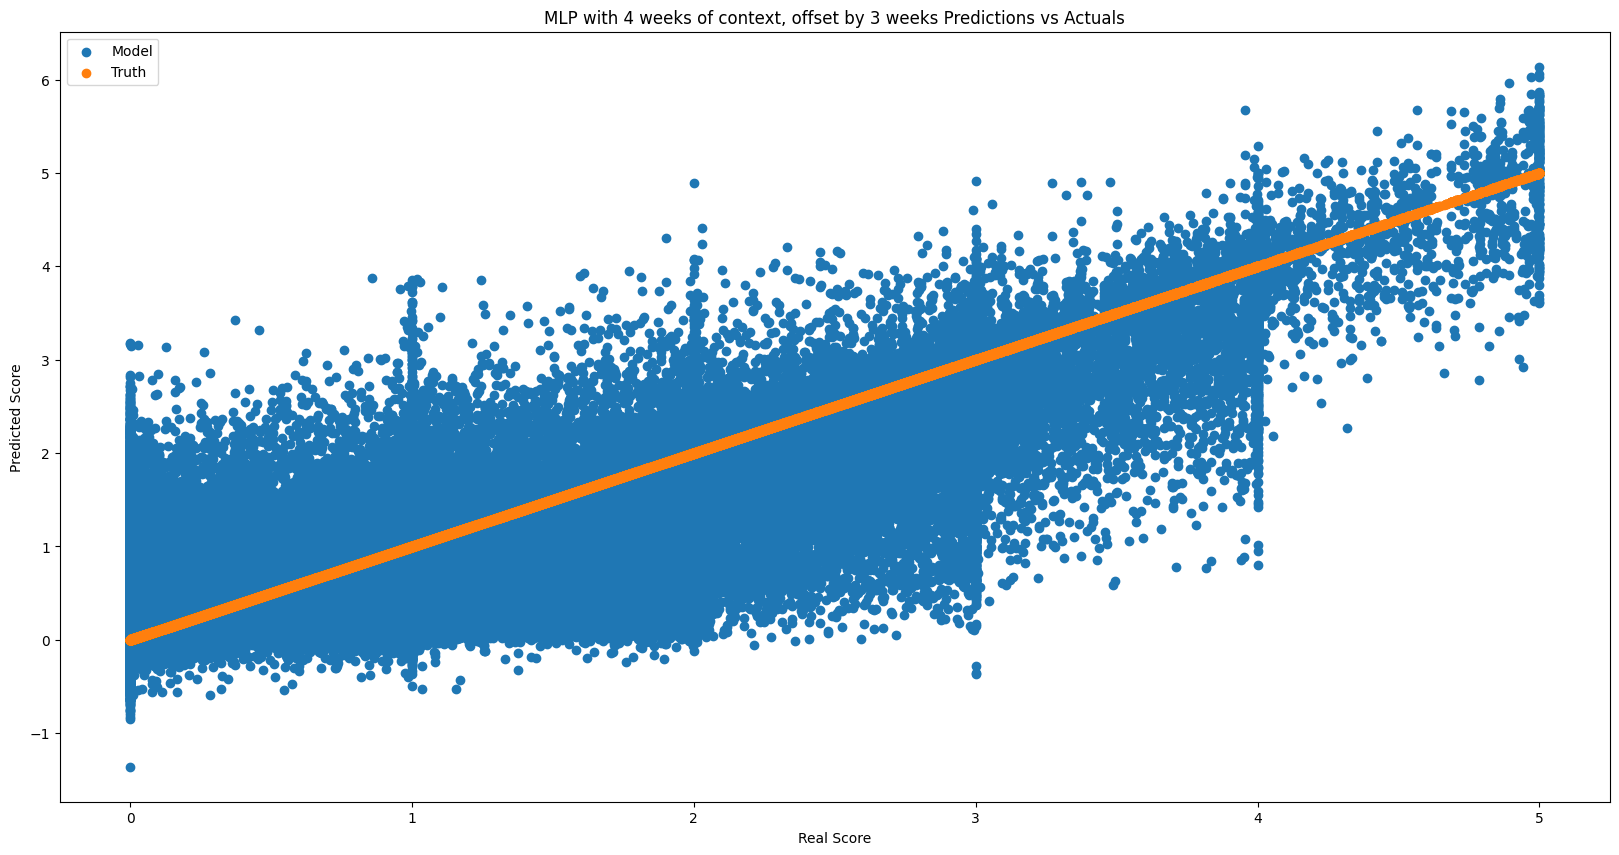

Mean Squared Error:  0.20102256884632236
Mean Absolute Error:  0.27769462127930766
R2 Score:  0.7178391769281822


In [ ]:
model5_preds = model5.predict(test4.drop(['score'],axis=1))
regression_metric(test4['score'], model5_preds, 'MLP with 4 weeks of context, offset by 3 weeks')

## Lag Feature analysis

I want to see what the correlation of lag features with the score column is, without any lagged scores present. I'm going to make it so that we are predicting 4 weeks out.

In [ ]:
train5, test5 = get_fresh_data()

In [ ]:
cols = train5.columns.to_list()
cols.remove('fips')
cols.remove('score')
cols.remove('lat')
cols.remove('long')
for x in cols:
    train5 = add_lag_features('fips',x,4,0,train5)
    test5 = add_lag_features('fips',x,4,0,test5)

train5 = add_lag_features('fips','score',5,4,train5)
test5 = add_lag_features('fips','score',5,4,test5)

In [ ]:
NUM_WEEKS_TO_FORECAST = 4

In [ ]:
train5 = shift_target(train5, NUM_WEEKS_TO_FORECAST, 'score', 'fips')
test5 = shift_target(test5, NUM_WEEKS_TO_FORECAST, 'score', 'fips')
train5 = rm_fips_null(train5)
test5 = rm_fips_null(test5)

In [ ]:
corr_mat = train5.cov() 

In [ ]:
corr_mat.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '10px'})

In [ ]:
pd.DataFrame(corr_mat['score'].sort_values(ascending=False)).head(20)

,score
T2M_MAX_lag_4,2.173065
T2M_MAX_lag_3,2.169697
T2M_MAX_lag_2,2.165255
T2M_MAX_lag_1,2.145306
T2M_MAX,2.129127
TS_lag_4,1.665921
TS_lag_3,1.658021
TS_lag_2,1.647876
TS_lag_1,1.622199
TS,1.595858


In [ ]:
corr_mat['score'].sort_values(ascending=False)['score_lag_5']

1.1139879995589779

In [ ]:
from catboost import CatBoostRegressor

model6 = CatBoostRegressor()
model6.fit(train5.drop(['score'],axis=1),train5['score'], verbose=False)

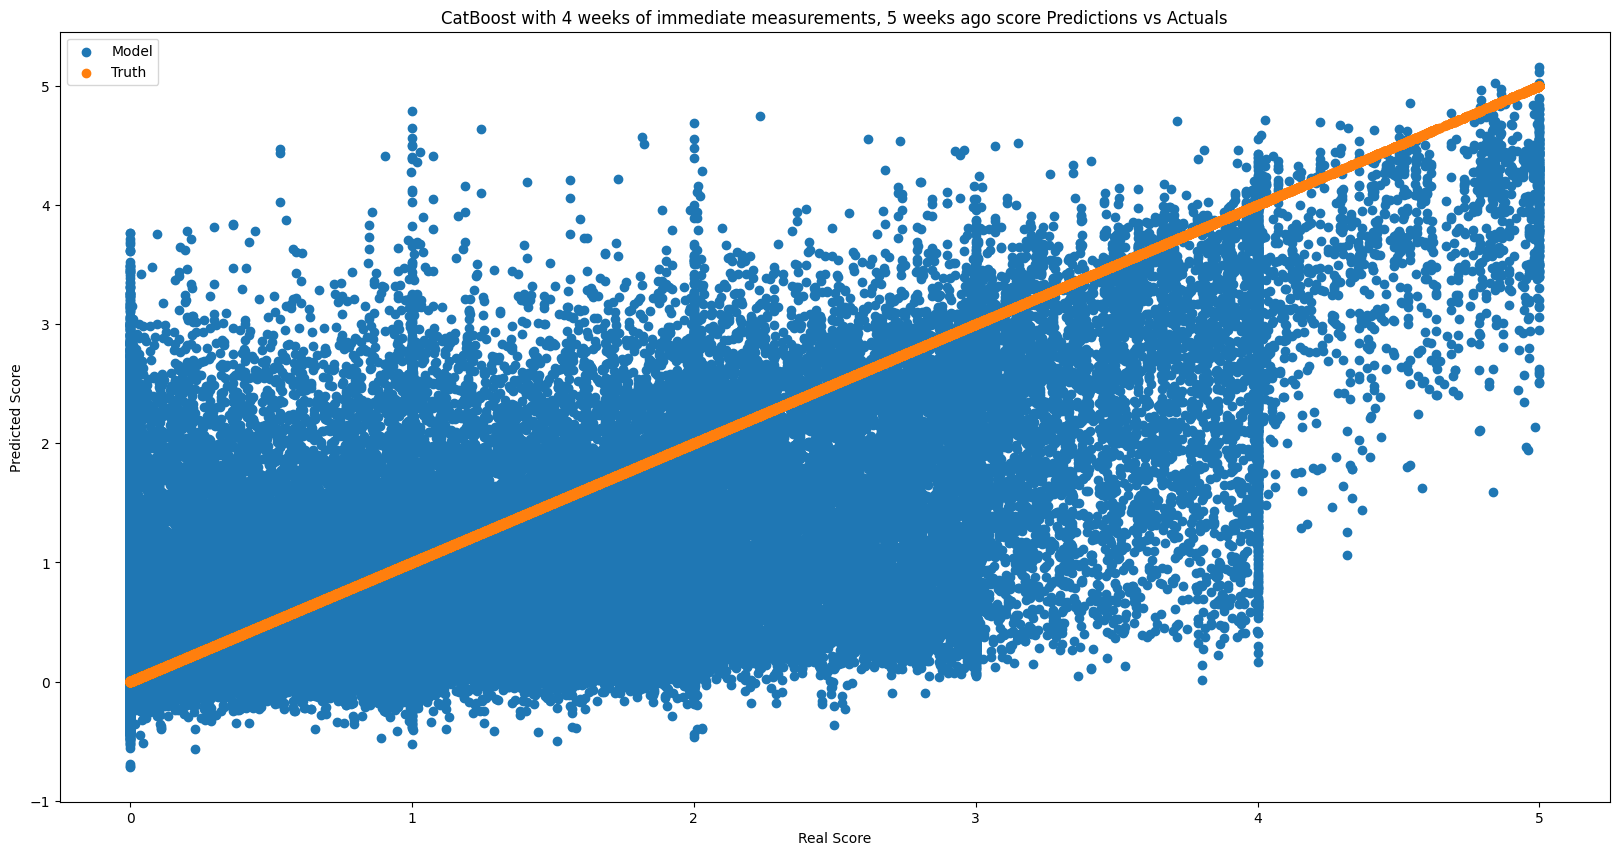

Mean Squared Error:  0.3894764951342707
Mean Absolute Error:  0.41292568271612584
R2 Score:  0.4633012256031167


In [ ]:
model6_preds = model6.predict(test5.drop(['score'],axis=1))
regression_metric(test5['score'], model6_preds, 'CatBoost with 4 weeks of immediate measurements, 5 weeks ago score')

In [ ]:
model6.get_feature_importance(prettified=True)

,Feature Id,Importances
0,score_lag_5,35.361595
1,long,8.863837
2,lat,4.439520
3,T2M_MAX,4.045708
4,TS,2.144993
...,...,...
88,WS10M_MIN_lag_3,0.032406
89,WS10M_MIN_lag_4,0.026806
90,WS50M_RANGE_lag_3,0.021418
91,WS10M_MIN_lag_2,0.019835


Unfortunately, it seems that with a far enough prediction horizon, some degree of recent score knowledge is needed. However, it is also apparent that not all of the lag features are contributing equally. Some of the lag features should be prioritized more, and some can be dropped. 

## Maximal Prediction threshold - FINAL MODELS
----

I want to see how far out we can predict using a catboost regressor, 4 weeks of score context, and intelligently lagged weather measurements.

In [41]:
trainf, testf = get_fresh_data()

trainf.columns

Index(['fips', 'PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX',
       'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN',
       'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE',
       'score', 'lat', 'long'],
      dtype='object')

In [42]:
tcols = [x for x in trainf.columns if 'T2' in x] #The non-wind columns seem to matter the most. Therefore, we'll lag these.
tcols.append("TS")
tcols.append("PRECTOT")
tcols.append("QV2M")
for x in tcols:
    trainf = add_lag_features('fips',x,2,0,trainf)
    testf = add_lag_features('fips',x,2,0,testf)

trainf = add_lag_features('fips','score',4,0,trainf) #we saw in our first experiment that after a few weeks of score context, it stopped mattering as much
testf = add_lag_features('fips','score',4,0,testf)

In [43]:
trainf_1 = shift_target(trainf, 1, 'score', 'fips')
testf_1 = shift_target(testf, 1, 'score', 'fips')

trainf_2 = shift_target(trainf, 2, 'score', 'fips')
testf_2 = shift_target(testf, 2, 'score', 'fips')

trainf_3 = shift_target(trainf, 3, 'score', 'fips')
testf_3 = shift_target(testf, 3, 'score', 'fips')

trainf_4 = shift_target(trainf, 4, 'score', 'fips')
testf_4 = shift_target(testf, 4, 'score', 'fips')

In [44]:
trainf_1 = rm_fips_null(trainf_1)
testf_1 = rm_fips_null(testf_1)

trainf_2 = rm_fips_null(trainf_2)
testf_2 = rm_fips_null(testf_2)

trainf_3 = rm_fips_null(trainf_3)
testf_3 = rm_fips_null(testf_3)

trainf_4 = rm_fips_null(trainf_4)
testf_4 = rm_fips_null(testf_4)

In [45]:
from catboost import CatBoostRegressor
import pickle

model7_1 = CatBoostRegressor()
model7_1.fit(trainf_1.drop(['score'],axis=1),trainf_1['score'], verbose=False)
model7_1_preds = model7_1.predict(testf_1.drop(['score'],axis=1))
pickle.dump(model7_1, open('model7_1_regression_experiments.pkl', 'wb'))

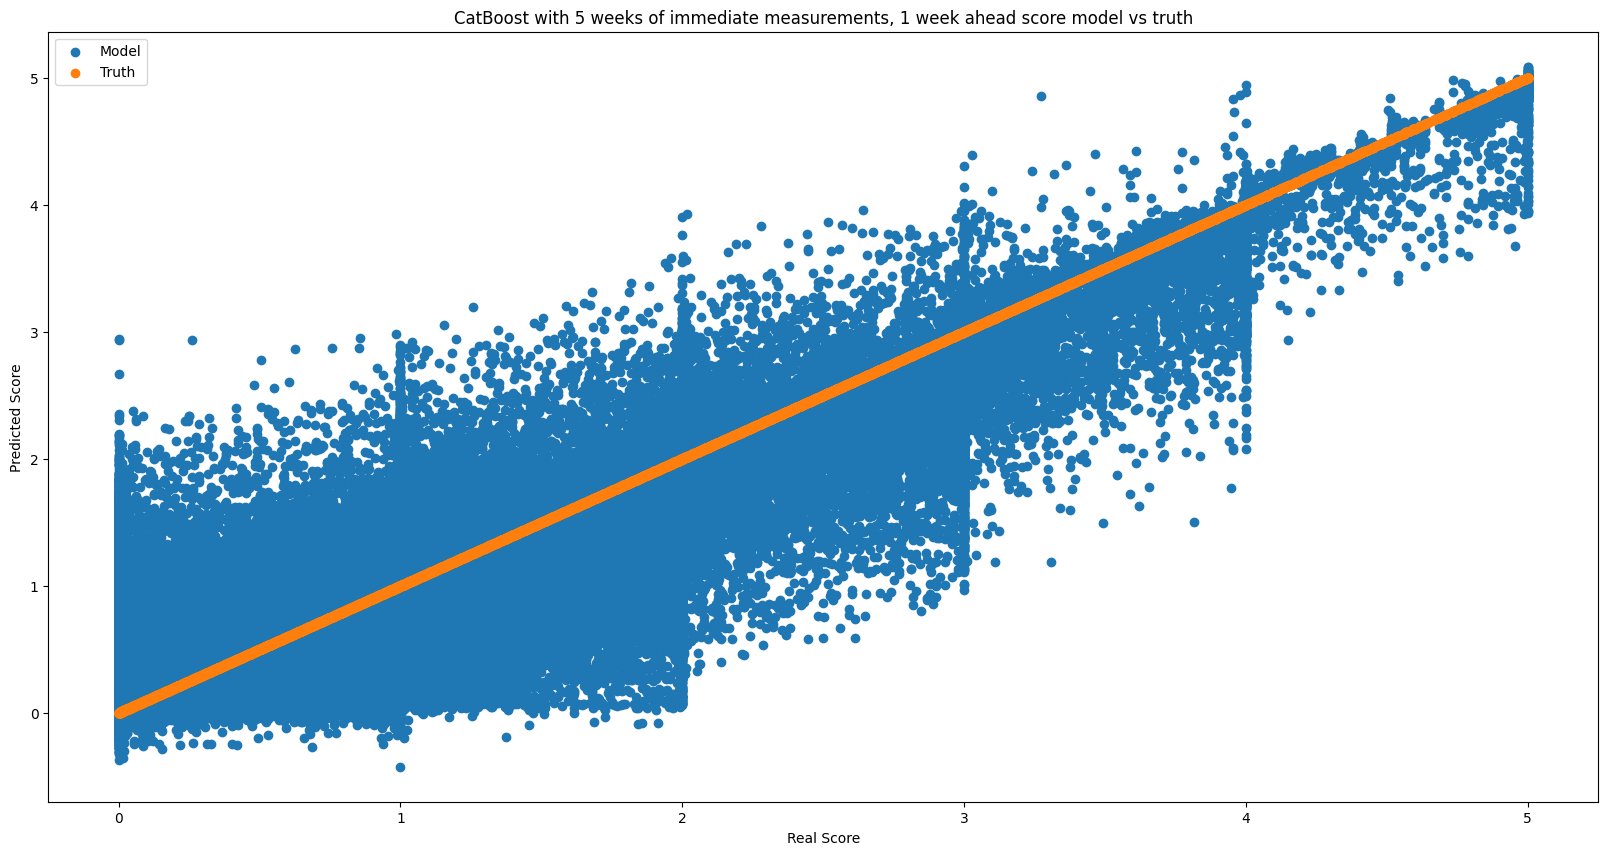

Mean Squared Error:  0.09967346130903913
Mean Absolute Error:  0.17288501993069866
R2 Score:  0.8600955800993886


In [46]:
regression_metric(testf_1['score'], model7_1_preds, 'CatBoost with 5 weeks of immediate measurements, 1 week ahead score')

In [47]:
model7_1.get_feature_importance(prettified=True)

,Feature Id,Importances
0,score_lag_1,70.510739
1,long,3.054581
2,PRECTOT,2.618419
3,PRECTOT_lag_1,2.436113
4,T2M_MAX,2.345041
5,TS,1.454292
6,lat,1.419453
7,QV2M,1.176310
8,T2M_RANGE,0.973026
9,score_lag_4,0.886738


In [48]:
from catboost import CatBoostRegressor
import pickle

model7_2 = CatBoostRegressor()
model7_2.fit(trainf_2.drop(['score'],axis=1),trainf_2['score'], verbose=False)
model7_2_preds = model7_2.predict(testf_2.drop(['score'],axis=1))

pickle.dump(model7_2, open('model7_2_regression_experiments.pkl', 'wb'))

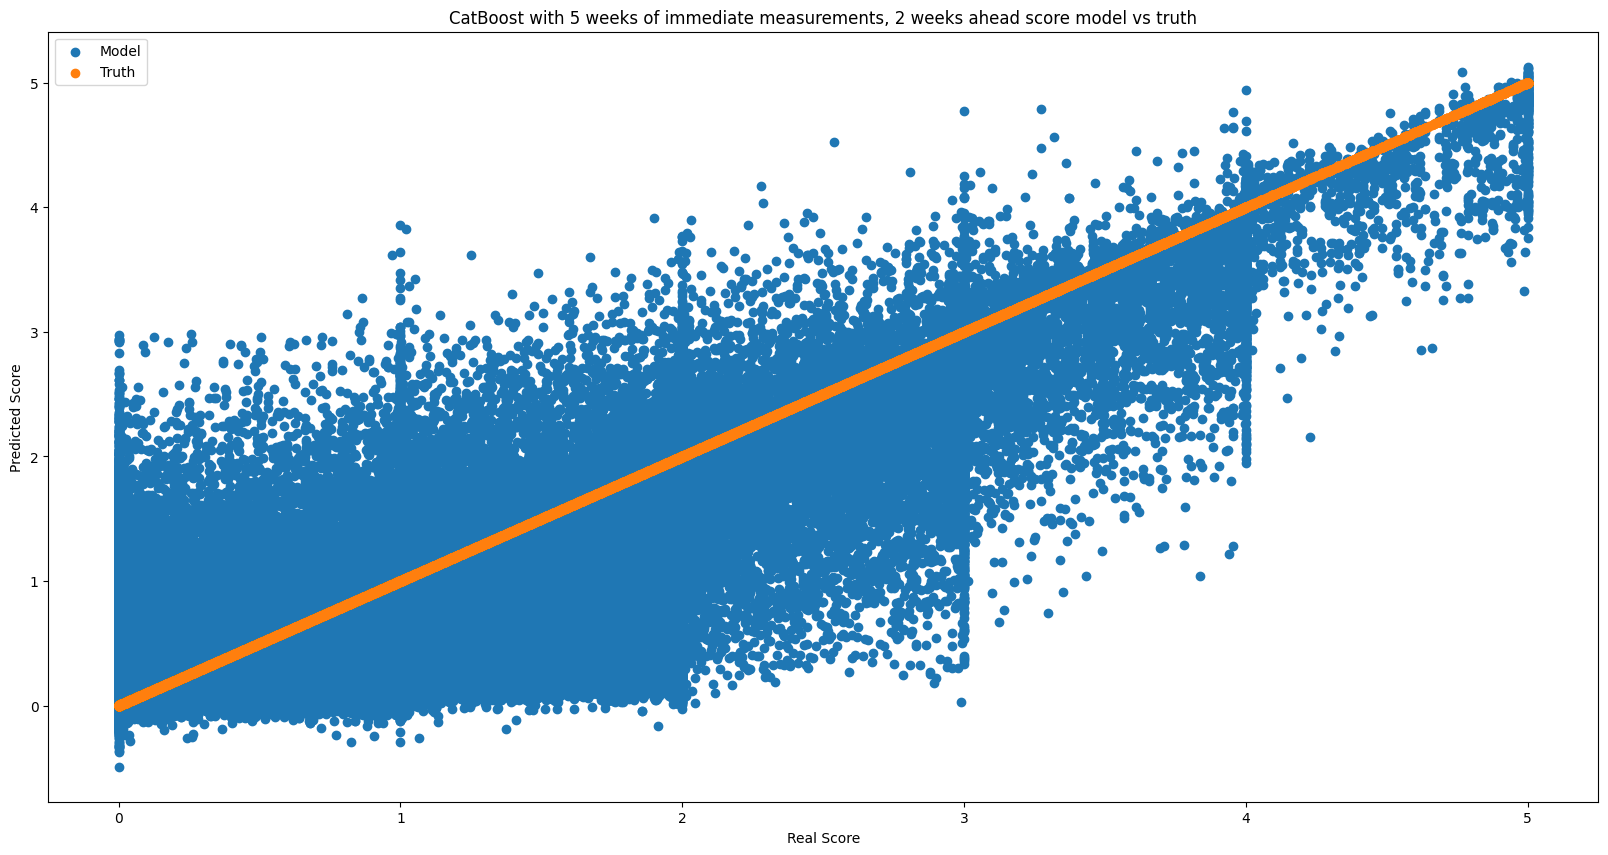

Mean Squared Error:  0.15548696008344767
Mean Absolute Error:  0.23079406762137986
R2 Score:  0.7826183540193296


In [49]:
regression_metric(testf_2['score'], model7_2_preds, 'CatBoost with 5 weeks of immediate measurements, 2 weeks ahead score')


In [50]:
model7_2.get_feature_importance(prettified=True)

,Feature Id,Importances
0,score_lag_1,61.890860
1,long,4.402948
2,PRECTOT,3.123321
3,PRECTOT_lag_1,2.705769
4,T2M_MAX,2.468338
5,lat,2.265255
6,TS,2.218787
7,QV2M,1.513951
8,T2M_RANGE,1.289790
9,T2M_MAX_lag_2,1.049980


In [51]:
from catboost import CatBoostRegressor
import pickle

model7_3 = CatBoostRegressor()
model7_3.fit(trainf_3.drop(['score'],axis=1),trainf_3['score'], verbose=False)
model7_3_preds = model7_3.predict(testf_3.drop(['score'],axis=1))

pickle.dump(model7_3, open('model7_3_regression_experiments.pkl', 'wb'))

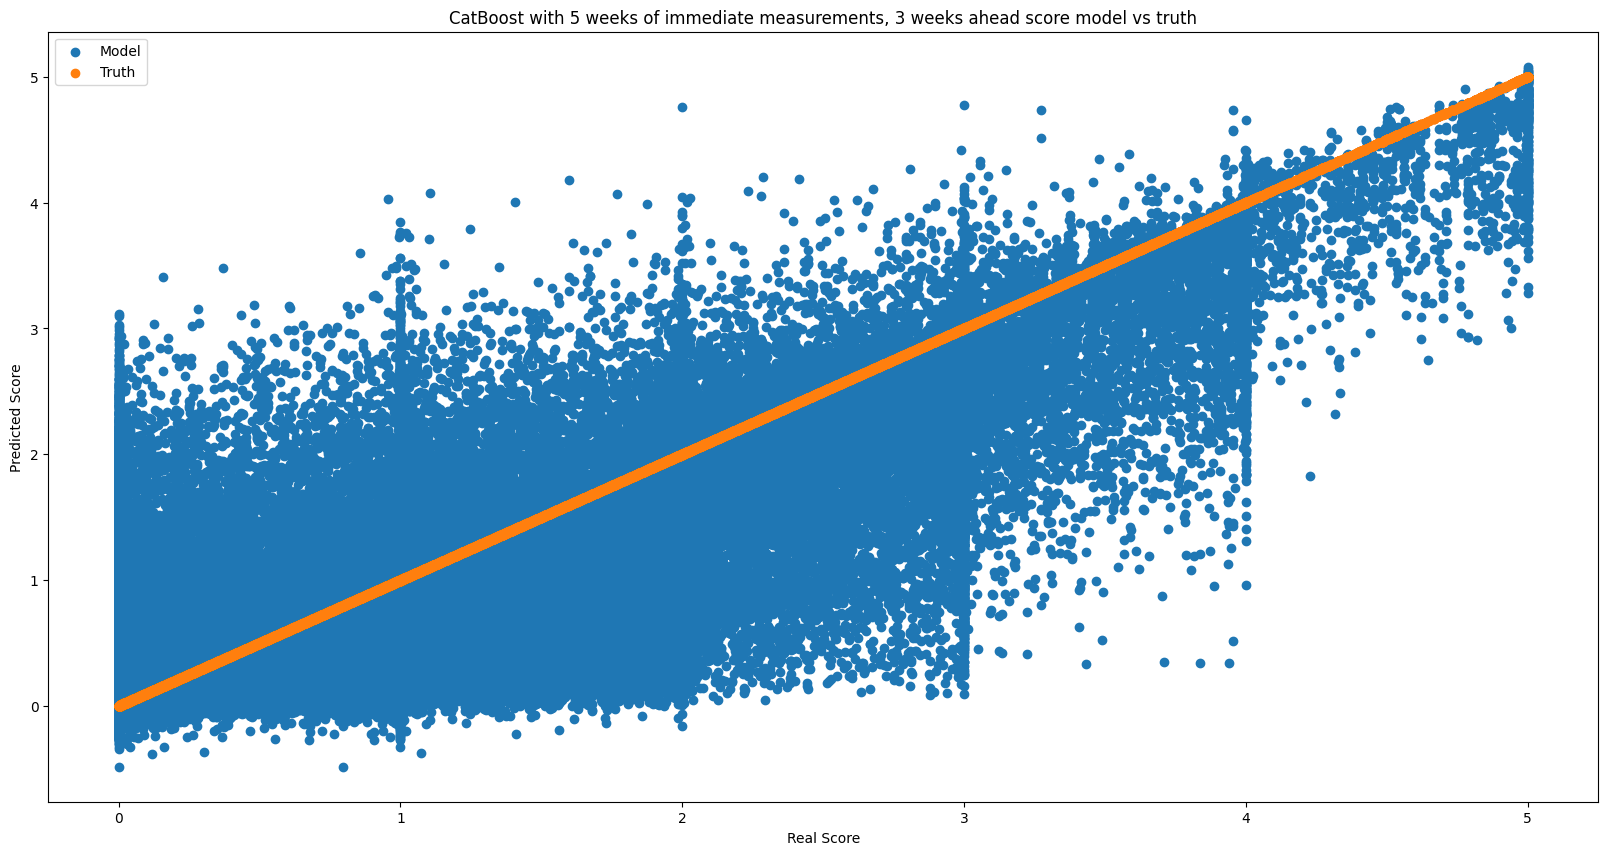

Mean Squared Error:  0.21538841353863392
Mean Absolute Error:  0.2825700315237343
R2 Score:  0.7001564711868669


In [52]:
regression_metric(testf_3['score'], model7_3_preds, 'CatBoost with 5 weeks of immediate measurements, 3 weeks ahead score')

In [53]:
model7_3.get_feature_importance(prettified=True)

,Feature Id,Importances
0,score_lag_1,52.516759
1,long,5.866870
2,PRECTOT,3.414899
3,T2M_MAX,3.170781
4,lat,3.135333
5,PRECTOT_lag_1,2.795736
6,TS,2.641982
7,QV2M,1.946771
8,T2M_RANGE,1.541035
9,score_lag_4,1.402900


In [54]:
from catboost import CatBoostRegressor
import pickle

model7_4 = CatBoostRegressor()
model7_4.fit(trainf_4.drop(['score'],axis=1),trainf_4['score'], verbose=False)
model7_4_preds = model7_4.predict(testf_4.drop(['score'],axis=1))

pickle.dump(model7_4, open('model7_4_regression_experiments.pkl', 'wb'))

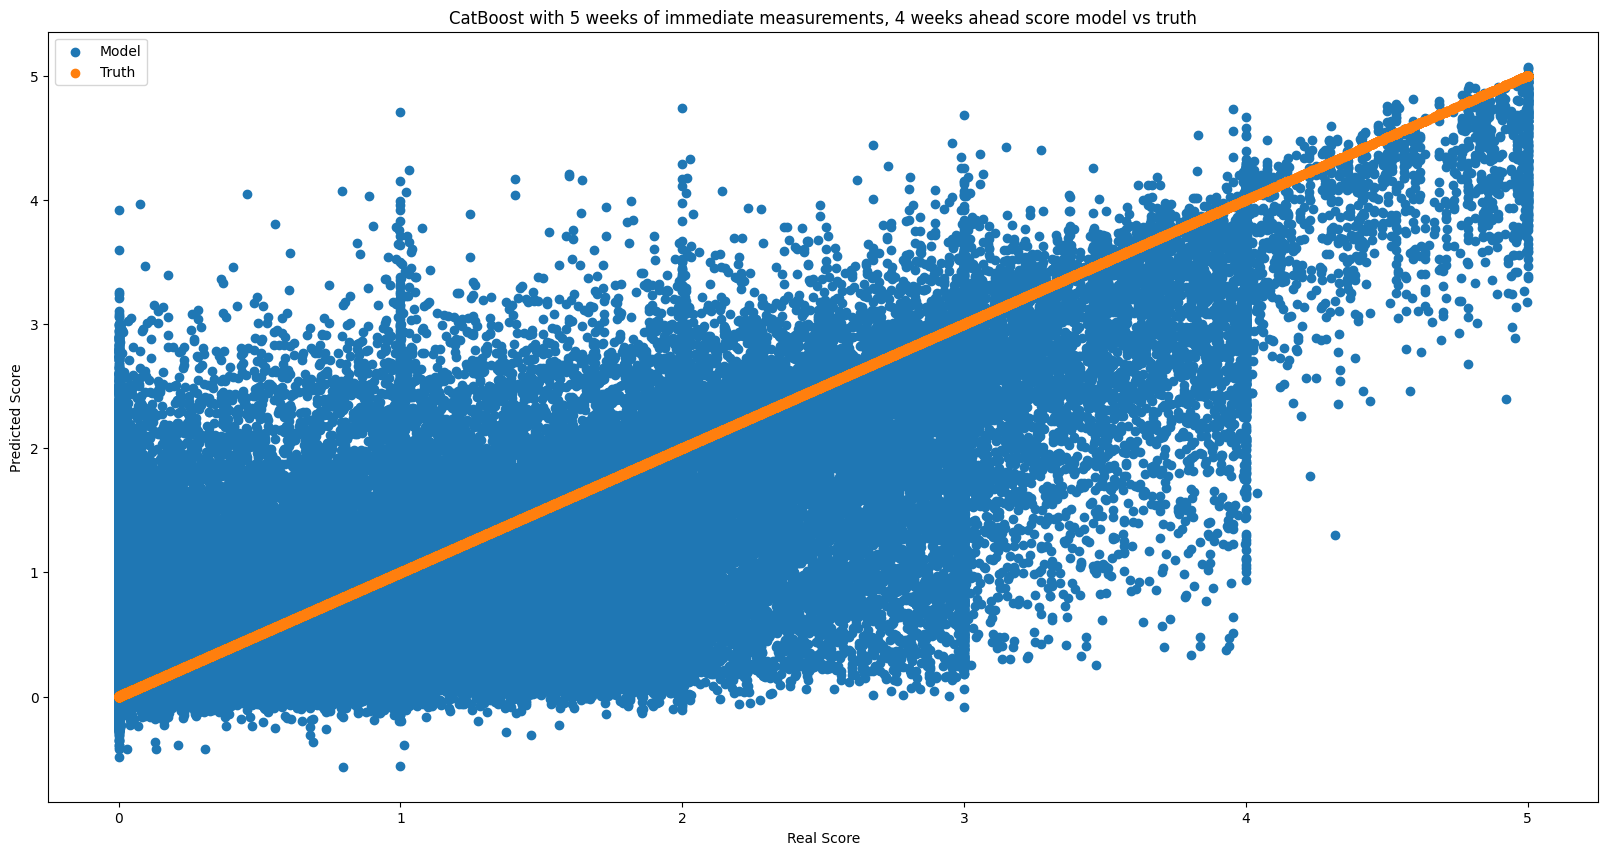

Mean Squared Error:  0.27363400510916747
Mean Absolute Error:  0.3276639013456602
R2 Score:  0.6208576369672352


In [55]:
regression_metric(testf_4['score'], model7_4_preds, 'CatBoost with 5 weeks of immediate measurements, 4 weeks ahead score')

In [56]:
model7_4.get_feature_importance(prettified=True)

,Feature Id,Importances
0,score_lag_1,46.535367
1,long,7.053993
2,lat,3.961840
3,PRECTOT,3.532556
4,T2M_MAX,3.251311
5,TS,2.896341
6,PRECTOT_lag_1,2.657442
7,QV2M,2.202651
8,T2M_RANGE,1.611590
9,score_lag_4,1.540310


As we can see very clearly, the R2 and MSE go up as we try to predict further and further out. It is possible that with additional feature engineering, we could extend our prediction horizon, but unfortunately, we did not get the time to try this. The time-series lag features are critical, especially knowledge of past scores. 

One interesting thing to note is that the decision tree based regressor seems to have "buckets" of predictions, denoted by vertical lines on the graph. This is interesting, and the cause of this is not entirely clear. A potential hypothesis is that this is an artefact of making discrete choices, and these buckets graphically show the terminal splits.

Furthermore, the models make intuitive sense. The ground truth from a week ago is the most important feature, followed by position (indicating biome), and precipitation. This is explainable, since drought inherently corresponds to these things.